In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pyLDAvis
import pyLDAvis.lda_model
import warnings
import re
import string
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings("ignore")
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\invok\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\invok\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
df = pd.read_csv("BBC News.csv")
print(df.head())

   ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
3       1976  lifestyle  governs mobile choice  faster  bett...      tech
4        917  enron bosses in $168m payout eighteen former e...  business


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


In [4]:
df.shape

(1490, 3)

In [5]:
df.duplicated().sum()

0

In [6]:
df.isna().sum()

ArticleId    0
Text         0
Category     0
dtype: int64

In [7]:
df.columns

Index(['ArticleId', 'Text', 'Category'], dtype='object')

In [8]:
df['Category'].value_counts()

Category
sport            346
business         336
politics         274
entertainment    273
tech             261
Name: count, dtype: int64

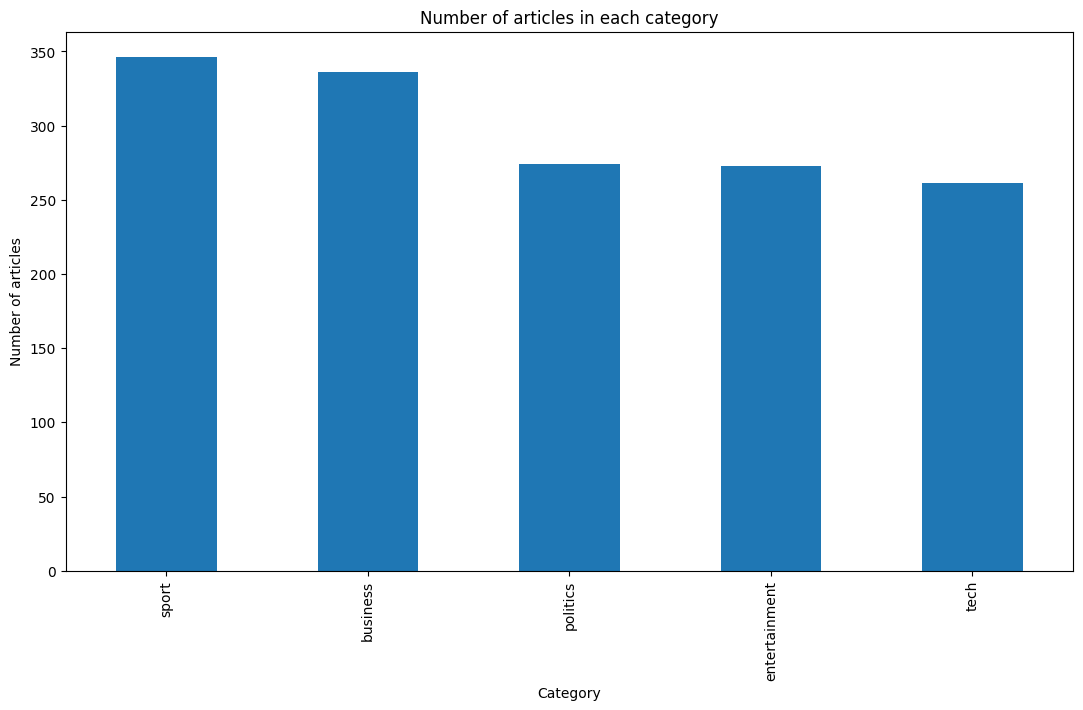

In [9]:
df['Category'].value_counts().plot(kind='bar', figsize = (13,7), title = 'Number of articles in each category', xlabel = 'Category', ylabel = 'Number of articles')
plt.show()

## Chart 1: Number of Articles in Each Category

This bar plot shows the distribution of articles across the five original BBC categories:
- **Sport** has the highest number of articles
- **Tech** has the lowest count
- The distribution is relatively balanced but not perfectly even

This helps us understand class balance and potential bias when interpreting topic model results.

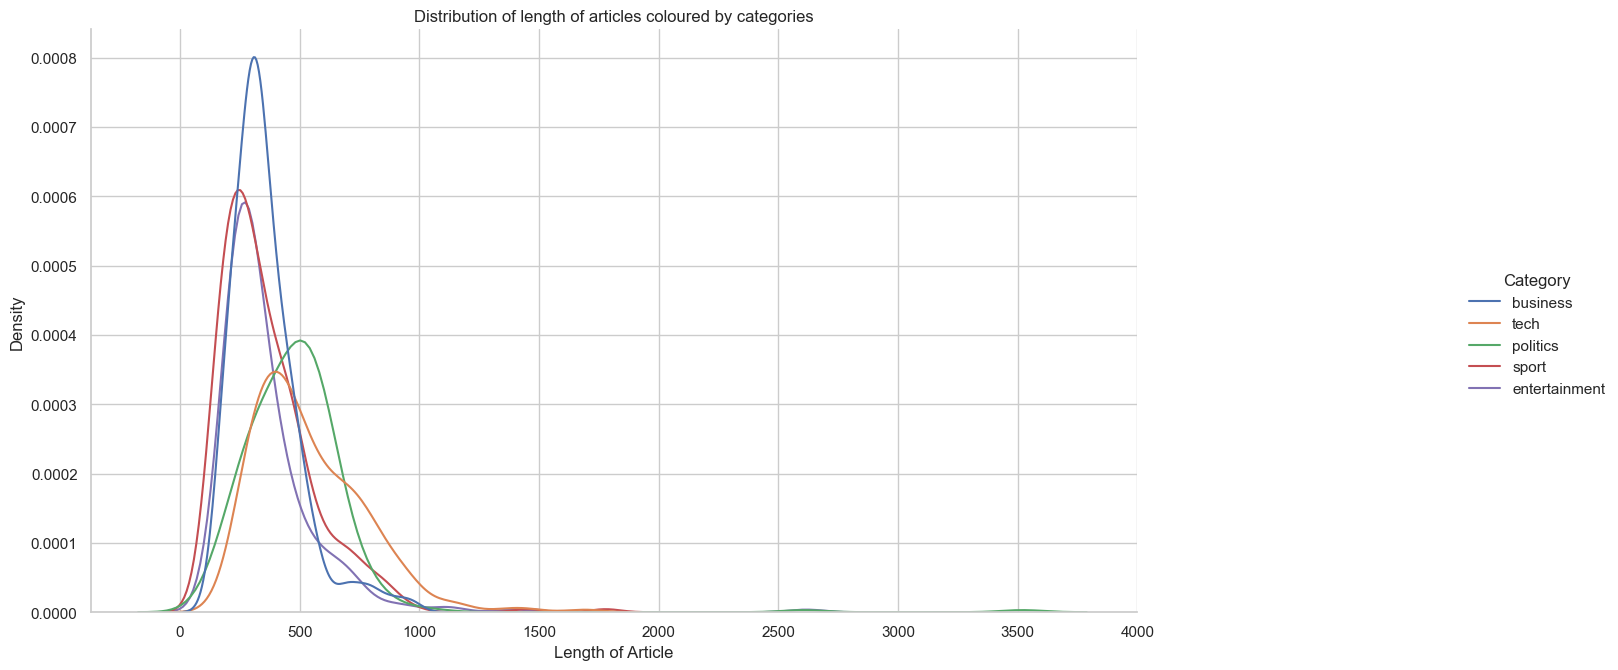

In [10]:
sns.set(style = 'whitegrid')
figu = sns.displot(x = df['Text'].str.split(' ').apply(len), hue = df['Category'], kind = 'kde')
figu.figure.set_size_inches(18,7)
figu.set(title = f'Distribution of length of articles coloured by categories', xlabel = 'Length of Article', xticks = range(0,4500,500))
plt.show()

## Chart 2: Article Length Distribution by Category

This KDE plot shows the distribution of article lengths (measured in word count), color-coded by category:
- Most articles fall between **250 and 1200 words**
- **Sport and Business articles** appear more consistently near the mean
- **Politics and Entertainment** have slightly longer tails, suggesting variation in content length

This variation in length can affect model performance, especially on longer vs shorter articles.

In [11]:
df.loc[1, 'Text']

'german business confidence slides german business confidence fell in february knocking hopes of a speedy recovery in europe s largest economy.  munich-based research institute ifo said that its confidence index fell to 95.5 in february from 97.5 in january  its first decline in three months. the study found that the outlook in both the manufacturing and retail sectors had worsened. observers had been hoping that a more confident business sector would signal that economic activity was picking up.   we re surprised that the ifo index has taken such a knock   said dz bank economist bernd weidensteiner.  the main reason is probably that the domestic economy is still weak  particularly in the retail trade.  economy and labour minister wolfgang clement called the dip in february s ifo confidence figure  a very mild decline . he said that despite the retreat  the index remained at a relatively high level and that he expected  a modest economic upswing  to continue.  germany s economy grew 1.

# Preprocessing

In [12]:
import contractions

In [13]:
def expand_contractions(text):
  '''Expands contractions in textual data'''
  expanded_words = []
  for word in text.split():
    expanded_words.append(contractions.fix(word))
  return ' '.join(expanded_words)

In [14]:
df['Text'] = df['Text'].apply(expand_contractions)

In [15]:
def make_lower(text):
  return text.lower()

In [16]:
df['Text'] = df['Text'].apply(make_lower)

In [17]:
def remove_punc(text):
  return re.sub(r'\W',' ',text)

In [18]:
df['Text'] = df['Text'].apply(remove_punc)

In [19]:
df.loc[1, 'Text']

'german business confidence slides german business confidence fell in february knocking hopes of a speedy recovery in europe s largest economy  munich based research institute ifo said that its confidence index fell to 95 5 in february from 97 5 in january its first decline in three months  the study found that the outlook in both the manufacturing and retail sectors had worsened  observers had been hoping that a more confident business sector would signal that economic activity was picking up  we re surprised that the ifo index has taken such a knock said dz bank economist bernd weidensteiner  the main reason is probably that the domestic economy is still weak particularly in the retail trade  economy and labour minister wolfgang clement called the dip in february s ifo confidence figure a very mild decline   he said that despite the retreat the index remained at a relatively high level and that he expected a modest economic upswing to continue  germany s economy grew 1 6  last year a

In [20]:
df['Text'].str.contains('http').sum()

0

In [21]:
# Functions for removing digits and whitespaces using re library
def remove_digits(text):
  return re.sub(r'\d',' ',text)

def remove_whitespace(text):
  return re.sub(r'\s+',' ',text)

In [22]:
df['Text'] = df['Text'].apply(remove_digits)
df['Text'] = df['Text'].apply(remove_whitespace)

In [23]:
df.loc[1, 'Text']

'german business confidence slides german business confidence fell in february knocking hopes of a speedy recovery in europe s largest economy munich based research institute ifo said that its confidence index fell to in february from in january its first decline in three months the study found that the outlook in both the manufacturing and retail sectors had worsened observers had been hoping that a more confident business sector would signal that economic activity was picking up we re surprised that the ifo index has taken such a knock said dz bank economist bernd weidensteiner the main reason is probably that the domestic economy is still weak particularly in the retail trade economy and labour minister wolfgang clement called the dip in february s ifo confidence figure a very mild decline he said that despite the retreat the index remained at a relatively high level and that he expected a modest economic upswing to continue germany s economy grew last year after shrinking in howeve

In [24]:
def remove_stopwords(text, stop_words):
  text = [word for word in text.split() if word.lower() not in stop_words]
  return ' '.join(text)

In [25]:
stop_words = stopwords.words('english')
df['Text'] = df['Text'].apply(remove_stopwords, stop_words = stop_words)

In [26]:
df.loc[1, 'Text']

'german business confidence slides german business confidence fell february knocking hopes speedy recovery europe largest economy munich based research institute ifo said confidence index fell february january first decline three months study found outlook manufacturing retail sectors worsened observers hoping confident business sector would signal economic activity picking surprised ifo index taken knock said dz bank economist bernd weidensteiner main reason probably domestic economy still weak particularly retail trade economy labour minister wolfgang clement called dip february ifo confidence figure mild decline said despite retreat index remained relatively high level expected modest economic upswing continue germany economy grew last year shrinking however economy contracted last three months mainly due reluctance consumers spend latest indications growth still proving elusive ifo president hans werner sinn said improvement german domestic demand sluggish exports kept things going

In [27]:
def top_n_words_features(count_vectorizer, text, n_words):
    vectorized = count_vectorizer.fit_transform(text)
    tokens_df = pd.DataFrame(vectorized.todense(), columns = count_vectorizer.get_feature_names_out())
    top_df = pd.DataFrame(tokens_df.sum().sort_values(ascending=False).head(n_words)).rename(columns = {0:'Occurences'})
    return top_df, len(count_vectorizer.get_feature_names_out())

In [28]:
vectorizer = CountVectorizer()
top_words, n_features_raw = top_n_words_features(vectorizer, df['Text'], 10)

<Axes: >

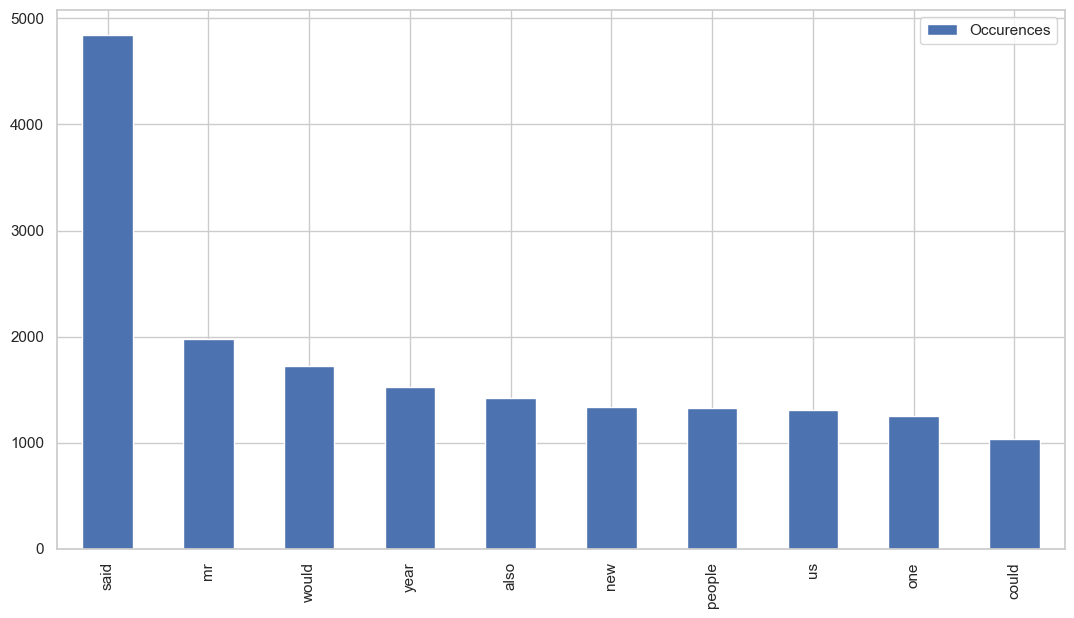

In [29]:
top_words.plot(kind='bar', figsize = (13,7))

In [30]:
n_features_raw

23374

In [31]:
# Function for lemmatizing the verbs
def lemmatize_(text, lemmatizer):
  text = [lemmatizer.lemmatize(word, pos='v') for word in text.split()]
  return ' '.join(text)

In [32]:
lemmatiser =  WordNetLemmatizer()
df['Text'] = df['Text'].apply(lemmatize_, lemmatizer = lemmatiser)

In [33]:
top_words, n_features = top_n_words_features(vectorizer, df['Text'], 10)

<Axes: >

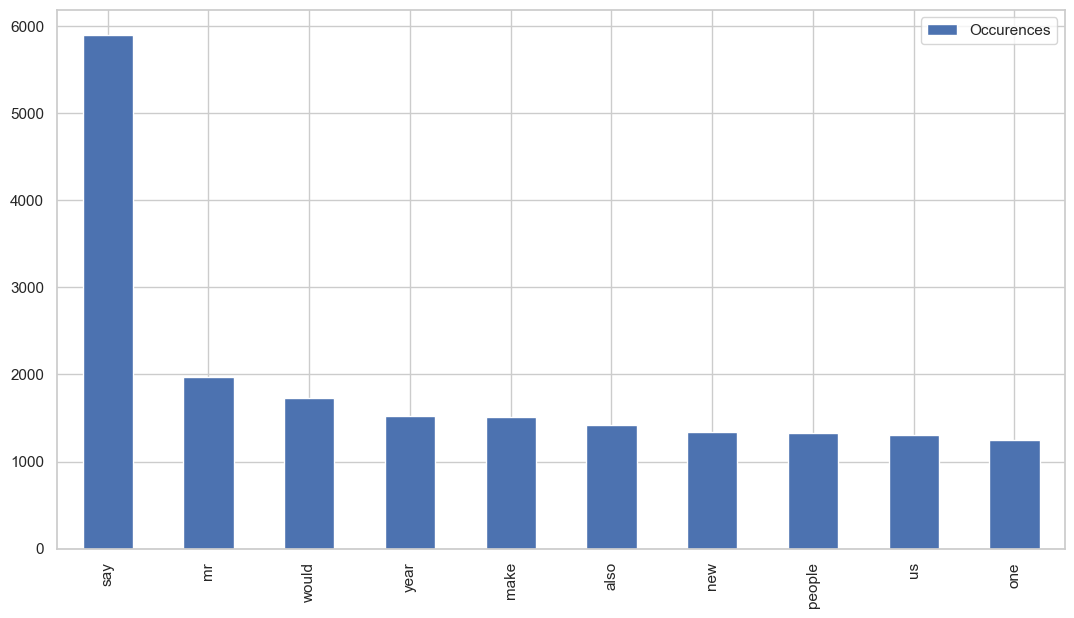

In [34]:
top_words.plot(kind='bar', figsize = (13,7))

In [35]:
stop_words.extend(['say', 'mr', 'would', 'also'])
df['Text'] = df['Text'].apply(remove_stopwords, stop_words = stop_words)

<Axes: >

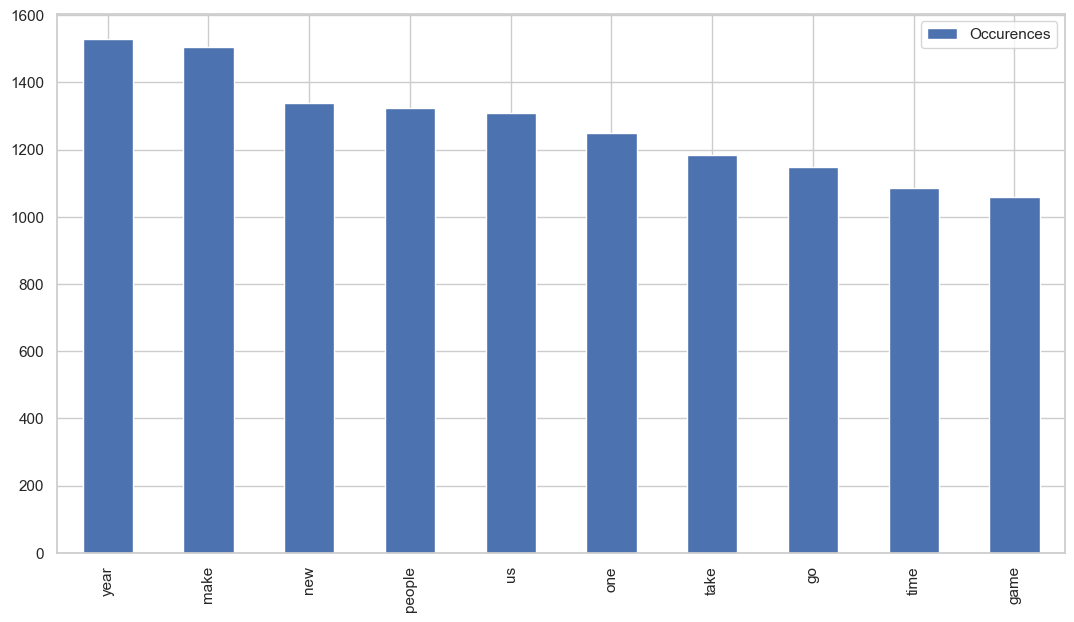

In [36]:
top_n_words_features(vectorizer, df['Text'], 10)[0].plot(kind='bar', figsize = (13,7))

###  Preprocessing

**Problem**:  
Raw text contains noise like punctuation, stopwords, inconsistent casing, and irregular word forms which reduce model quality.

**What We Did**:  
- Lowercased all text  
- Expanded contractions  
- Removed punctuation, digits, and extra whitespace  
- Removed stopwords (including a custom extended list)  
- Applied **lemmatization** using WordNetLemmatizer

**Why**:  
- Clean text ensures better tokenization and more meaningful topics  
- Lemmatization ensures related words (e.g., “run”, “running”) are treated as one  
- Removing noise helps the model focus on content-bearing words

In [37]:
# Vectorizing Text
tokeniser = CountVectorizer(max_df = 0.95, min_df = 0.02)
tokenised_data = tokeniser.fit_transform(df['Text'])

In [38]:
vectorizer_tfidf = TfidfVectorizer(max_df=0.95, min_df=0.02, max_features=3000)
data_tfidf = vectorizer_tfidf.fit_transform(df['Text'])

In [39]:
top_words, n_features = top_n_words_features(tokeniser, df['Text'], 10)

<Axes: >

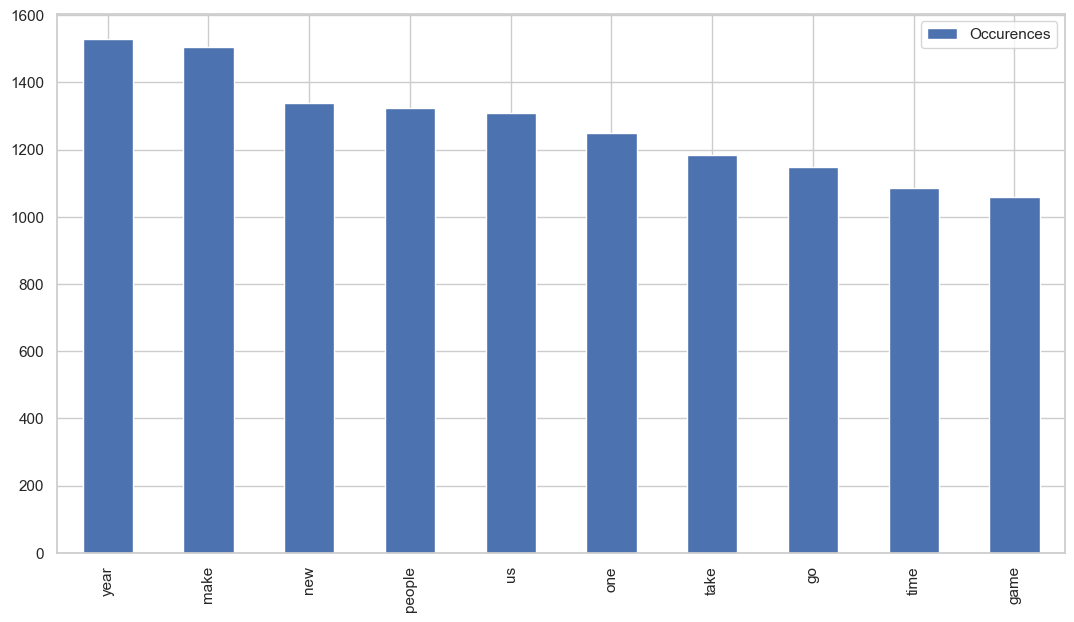

In [40]:
top_words.plot(kind = 'bar', figsize = (13,7))

In [41]:
print(f'Number of features after vectorization = {n_features}')
print(f'\nAfter Text Pre-processing, {round((n_features_raw - n_features)*100/n_features_raw, 2)}% of contextually insignificant features have been removed')

Number of features after vectorization = 1472

After Text Pre-processing, 93.7% of contextually insignificant features have been removed


### Vectorization

**Problem**:  
Machine learning models cannot work directly with raw text — we needed to convert it into numerical form.

**What We Did**:  
- Used **CountVectorizer** for LDA  
- Used **TfidfVectorizer** for NMF  
- Applied `max_df=0.95`, `min_df=0.02` to filter rare and overly common words

**Why**:  
- CountVectorizer is preferred for probabilistic models like LDA  
- TF-IDF helps NMF emphasize unique and meaningful words  
- Limiting document frequency reduces noise and sparsity in the document-term matrix

# Modelling

In [42]:
from sklearn.manifold import TSNE

def plot_tsne(doc_topic_matrix, model_name, perplexity=30):
    # Get dominant topic per document
    dominant_topics = doc_topic_matrix.argmax(axis=1)
    
    # Apply t-SNE
    tsne_model = TSNE(n_components=2, perplexity=perplexity, random_state=42, init='pca')
    tsne_result = tsne_model.fit_transform(doc_topic_matrix)
    
    # Plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=tsne_result[:,0], y=tsne_result[:,1], hue=dominant_topics, palette='tab10', s=50)
    plt.title(f't-SNE Plot of Document Clusters ({model_name})')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend(title='Topic')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [43]:
# Trying different lda settings
lda_hyperparams = [
    {'n_components': 3, 'learning_decay': 0.5},
    {'n_components': 3, 'learning_decay': 0.7},
    {'n_components': 5, 'learning_decay': 0.5},
    {'n_components': 5, 'learning_decay': 0.7},
    {'n_components': 7, 'learning_decay': 0.5},
    {'n_components': 7, 'learning_decay': 0.7}
]

In [44]:
lda_results = []

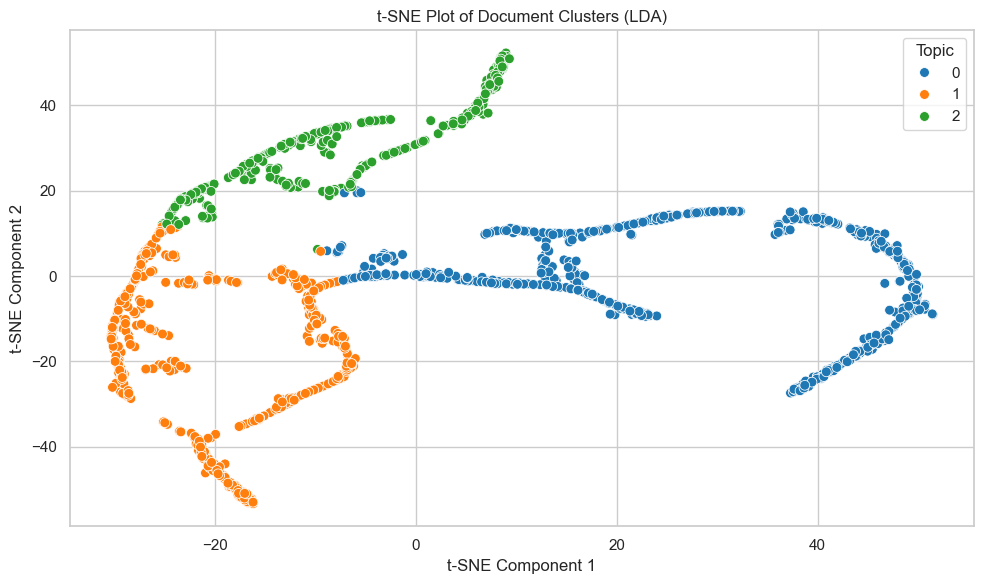

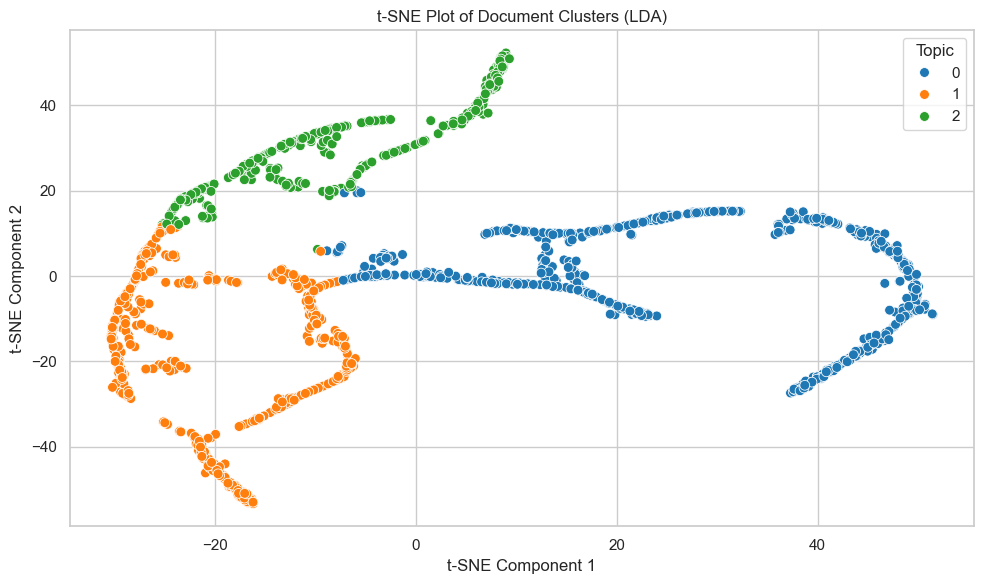

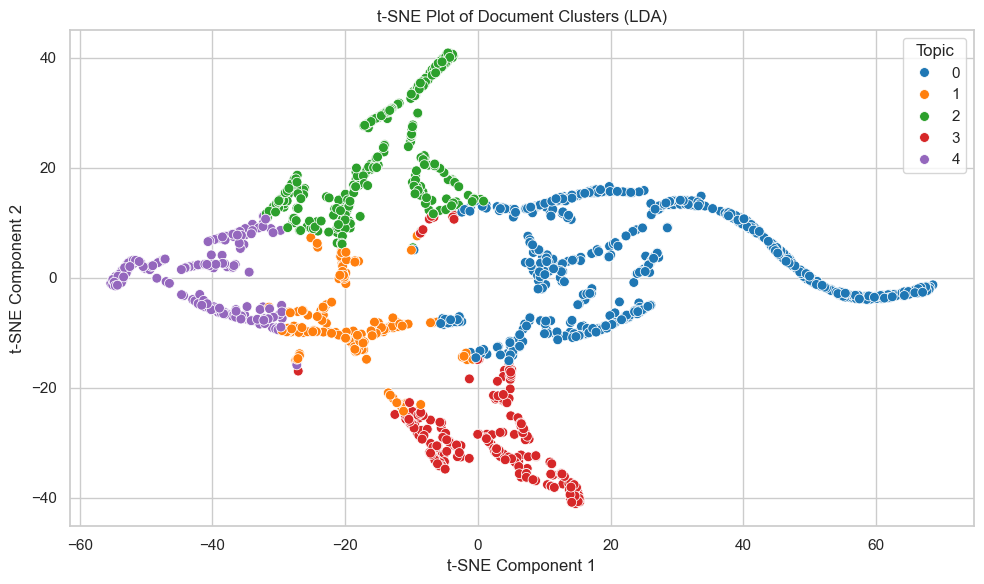

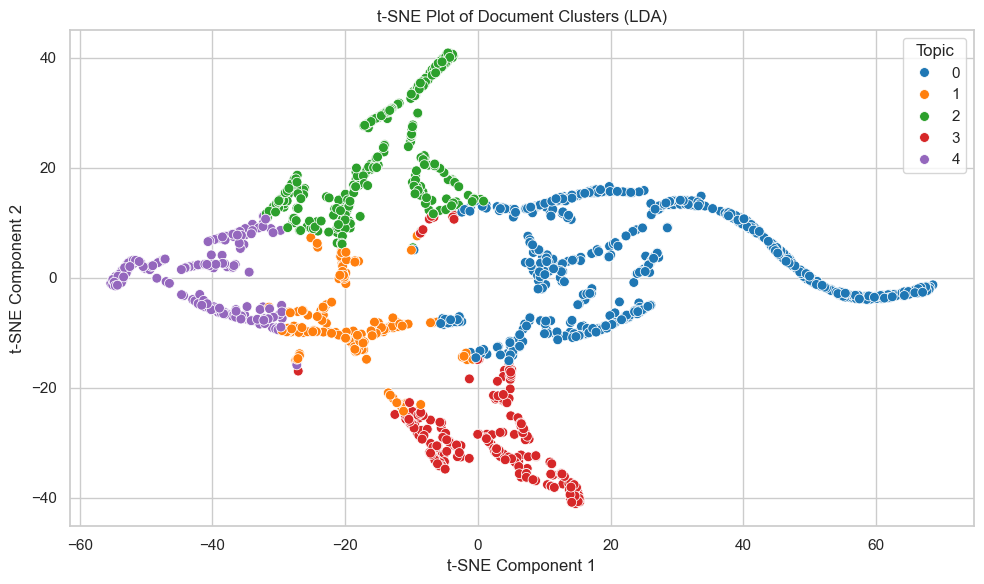

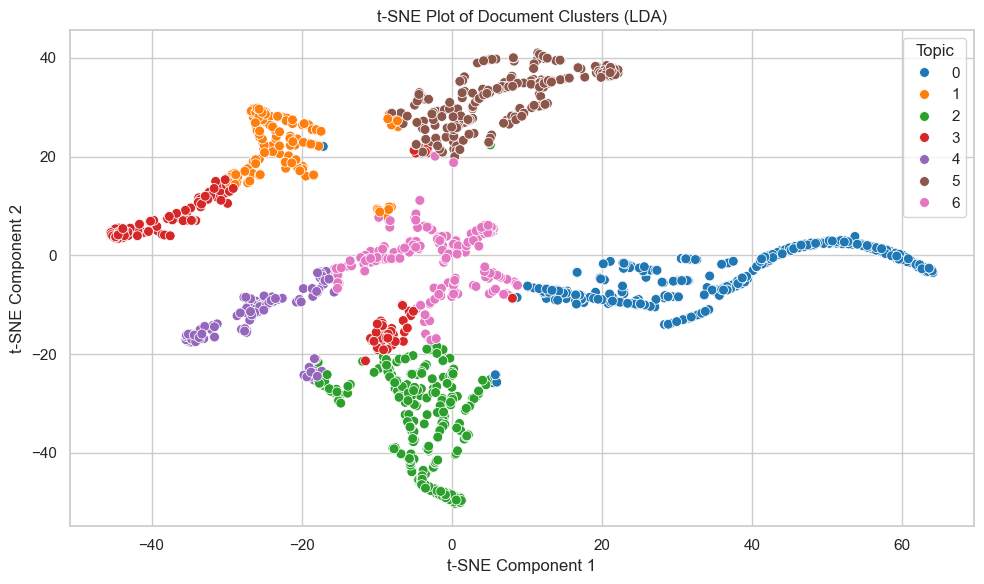

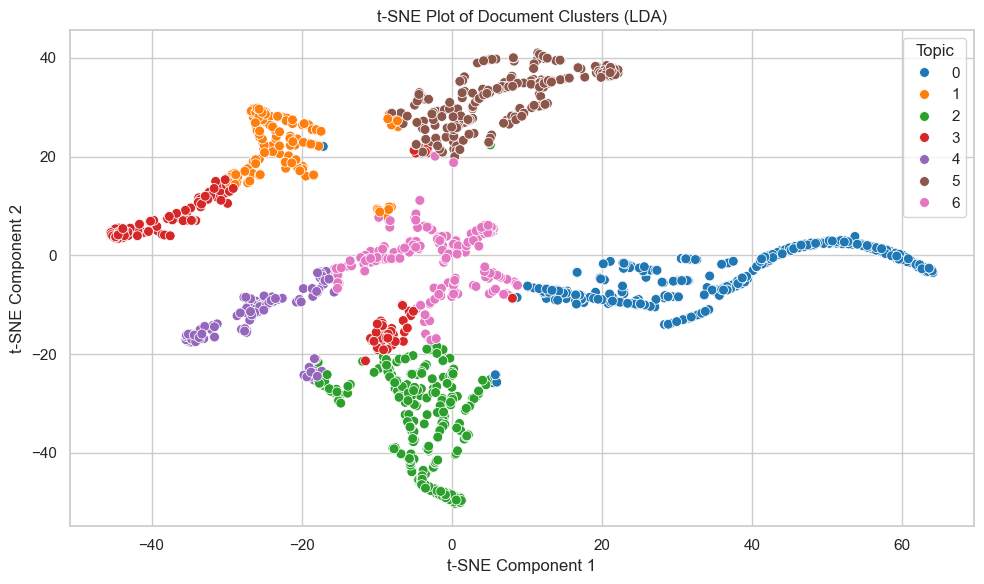

In [45]:
# Training LDA model
for params in lda_hyperparams:
    lda = LatentDirichletAllocation(n_components=params['n_components'],
                                    learning_decay=params['learning_decay'],
                                    random_state=42)
    lda.fit(tokenised_data)
    
    perplexity = lda.perplexity(tokenised_data)
    word_topic_dist = lda.components_
    doc_topic_dist = lda.transform(tokenised_data)
    plot_tsne(doc_topic_dist, model_name="LDA")
    
    lda_results.append({
        'model': lda,
        'params': params,
        'perplexity': perplexity,
        'word_topic_dist': word_topic_dist,
        'doc_topic_dist': doc_topic_dist
    })

In [46]:
print("\nLDA Model Evaluation:\n")
feature_names = tokeniser.get_feature_names_out()

for idx, res in enumerate(lda_results, 1):
    print(f"Model {idx}: Params={res['params']}, Perplexity={res['perplexity']:.2f}")
    print("Top 10 words per topic:")
    for topic_idx, topic in enumerate(res['word_topic_dist']):
        top_features = [feature_names[i] for i in topic.argsort()[:-11:-1]]
        print(f" Topic {topic_idx+1}: {', '.join(top_features)}")


LDA Model Evaluation:

Model 1: Params={'n_components': 3, 'learning_decay': 0.5}, Perplexity=843.41
Top 10 words per topic:
 Topic 1: game, film, play, year, go, first, win, best, one, time
 Topic 2: people, use, make, could, new, service, government, party, labour, one
 Topic 3: us, bn, year, market, company, firm, rise, bank, tax, share
Model 2: Params={'n_components': 3, 'learning_decay': 0.7}, Perplexity=843.41
Top 10 words per topic:
 Topic 1: game, film, play, year, go, first, win, best, one, time
 Topic 2: people, use, make, could, new, service, government, party, labour, one
 Topic 3: us, bn, year, market, company, firm, rise, bank, tax, share
Model 3: Params={'n_components': 5, 'learning_decay': 0.5}, Perplexity=786.26
Top 10 words per topic:
 Topic 1: film, game, play, year, best, win, go, first, time, take
 Topic 2: phone, people, mobile, use, make, court, could, uk, government, take
 Topic 3: us, year, bn, market, company, firm, rise, bank, sales, growth
 Topic 4: people,

In [47]:
# Trying different nmf settings
nmf_hyperparams = [
    {'n_components': 5}, {'n_components': 6}, {'n_components': 7},
    {'n_components': 8}, {'n_components': 9}, {'n_components': 10}
]

In [48]:
nmf_results = []
feature_names = vectorizer_tfidf.get_feature_names_out()

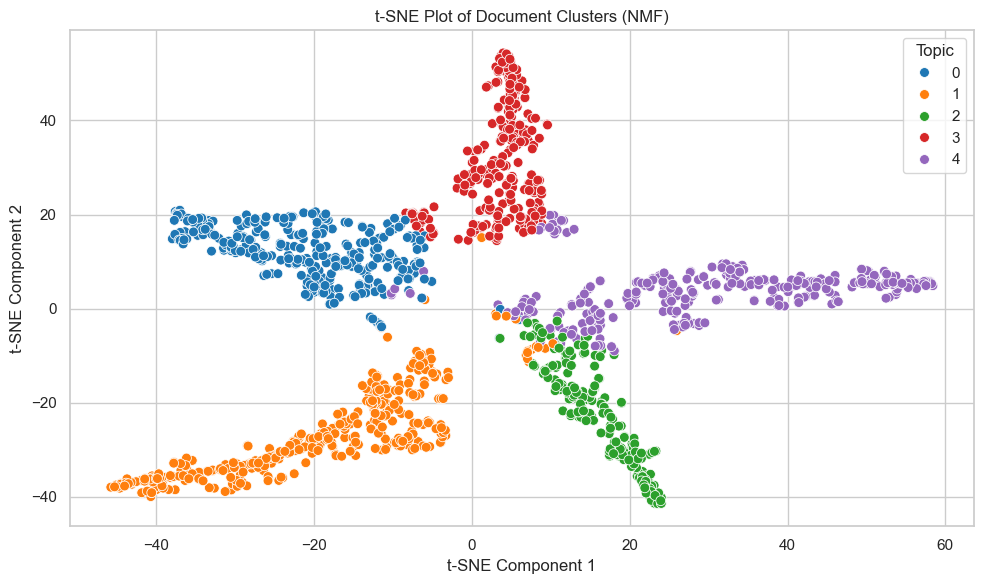

🔹 Model 1: Params={'n_components': 5}, Reconstruction Error=36.02
Top 10 words per topic:
  Topic 1: bn, us, market, firm, company, bank, growth, rise, share, profit
  Topic 2: game, play, win, england, match, first, cup, team, champion, side
  Topic 3: film, award, best, star, actor, oscar, actress, director, festival, include
  Topic 4: labour, election, blair, party, brown, minister, government, tax, howard, prime
  Topic 5: phone, use, people, mobile, service, music, technology, users, software, digital


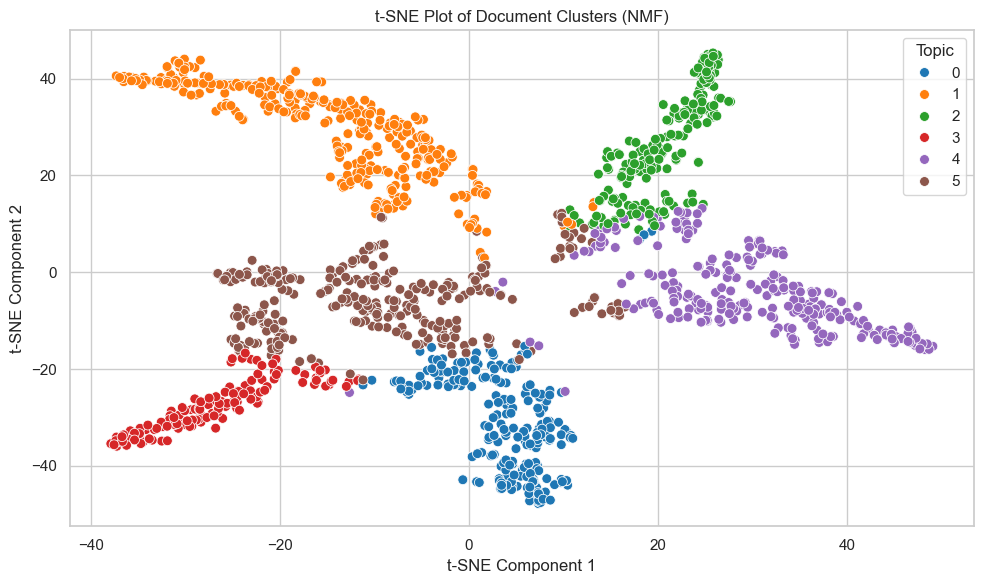

🔹 Model 2: Params={'n_components': 6}, Reconstruction Error=35.86
Top 10 words per topic:
  Topic 1: bn, market, growth, rise, bank, us, profit, sales, firm, economy
  Topic 2: game, play, win, england, match, first, cup, team, champion, side
  Topic 3: film, award, best, star, actor, oscar, actress, festival, director, include
  Topic 4: labour, election, party, blair, brown, tax, minister, howard, prime, campaign
  Topic 5: phone, mobile, use, people, service, music, technology, users, digital, software
  Topic 6: court, law, government, lord, eu, rule, police, case, bill, charge


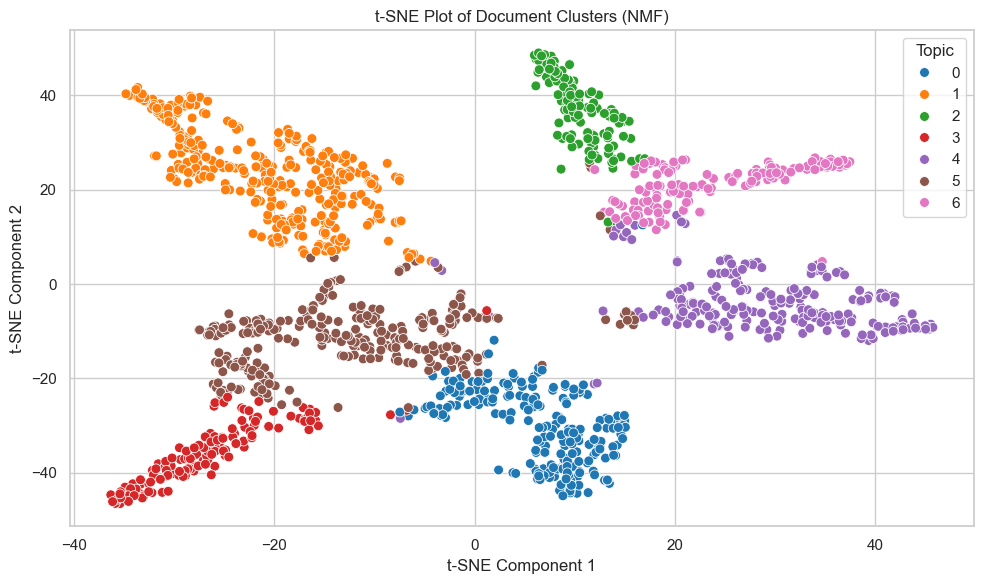

🔹 Model 3: Params={'n_components': 7}, Reconstruction Error=35.70
Top 10 words per topic:
  Topic 1: bn, market, growth, rise, bank, us, profit, firm, economy, share
  Topic 2: game, play, win, england, match, cup, team, side, first, champion
  Topic 3: film, award, best, star, actor, oscar, actress, director, festival, nominate
  Topic 4: labour, election, party, blair, brown, tax, minister, howard, campaign, prime
  Topic 5: phone, mobile, use, people, service, users, technology, software, net, microsoft
  Topic 6: court, law, government, lord, eu, rule, police, case, bill, charge
  Topic 7: band, music, album, chart, single, top, record, number, rock, song


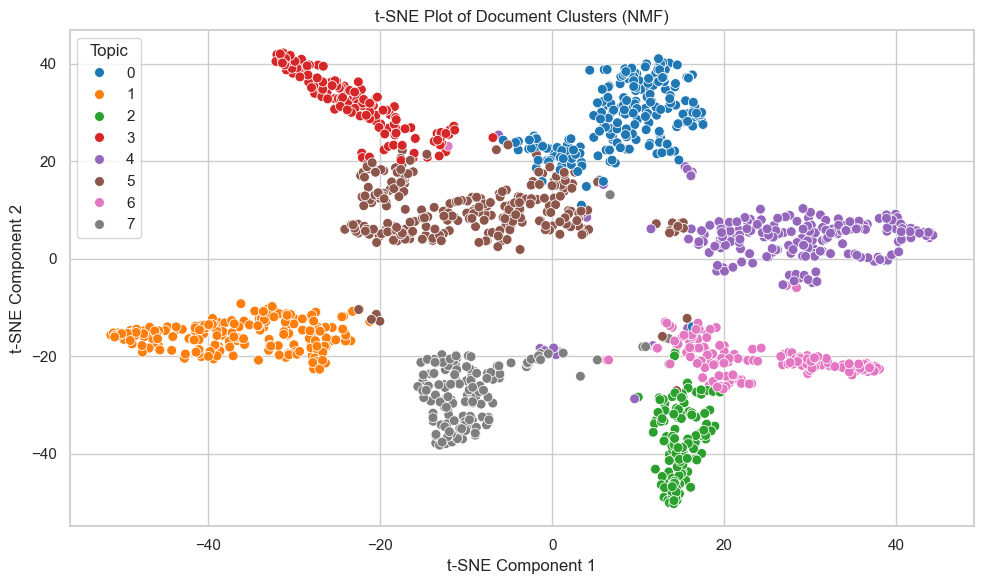

🔹 Model 4: Params={'n_components': 8}, Reconstruction Error=35.55
Top 10 words per topic:
  Topic 1: bn, market, growth, rise, bank, us, profit, firm, economy, share
  Topic 2: england, win, ireland, wales, match, france, play, first, game, final
  Topic 3: film, award, best, star, actor, oscar, actress, director, festival, nominate
  Topic 4: labour, election, party, blair, brown, tax, minister, howard, campaign, prime
  Topic 5: phone, mobile, use, people, service, users, technology, software, net, microsoft
  Topic 6: court, law, government, lord, eu, rule, police, case, bill, charge
  Topic 7: band, music, album, chart, single, top, record, number, rock, show
  Topic 8: game, club, chelsea, unite, arsenal, league, play, players, liverpool, manchester


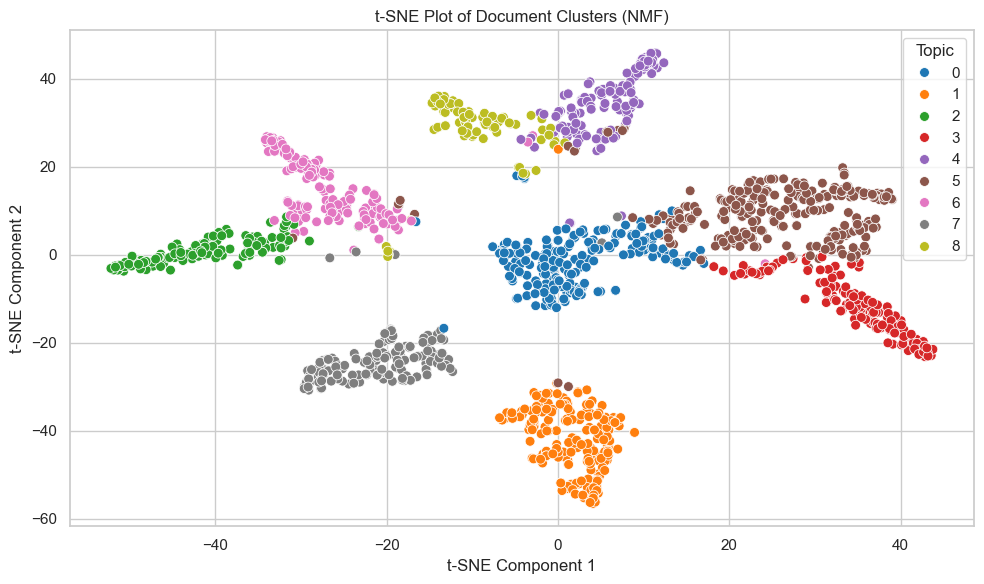

🔹 Model 5: Params={'n_components': 9}, Reconstruction Error=35.40
Top 10 words per topic:
  Topic 1: bn, market, growth, rise, bank, us, firm, profit, share, economy
  Topic 2: england, win, ireland, wales, match, france, play, game, first, final
  Topic 3: film, award, best, star, actor, oscar, actress, director, festival, nominate
  Topic 4: labour, election, party, blair, brown, tax, minister, howard, campaign, prime
  Topic 5: mail, software, microsoft, users, search, virus, program, net, security, use
  Topic 6: court, government, law, lord, eu, rule, police, case, bill, test
  Topic 7: band, music, album, chart, single, top, record, number, show, rock
  Topic 8: game, club, chelsea, unite, arsenal, league, play, liverpool, players, manchester
  Topic 9: phone, mobile, use, people, technology, service, digital, mobiles, music, game


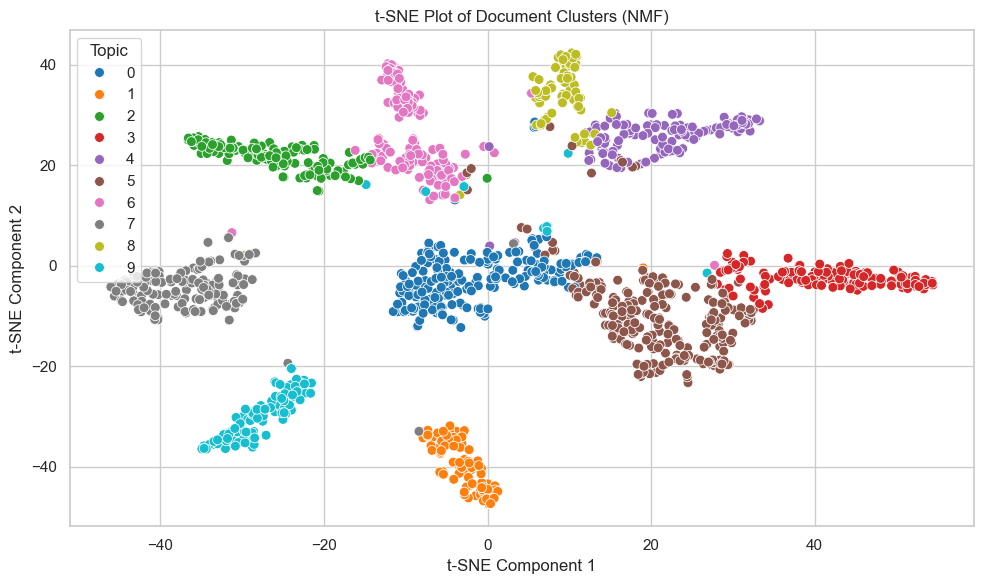

🔹 Model 6: Params={'n_components': 10}, Reconstruction Error=35.25
Top 10 words per topic:
  Topic 1: bn, market, growth, rise, bank, us, firm, profit, share, economy
  Topic 2: england, ireland, wales, france, nations, robinson, half, six, side, rugby
  Topic 3: film, award, best, star, actor, oscar, actress, director, festival, nominate
  Topic 4: labour, election, party, blair, brown, tax, minister, howard, campaign, prime
  Topic 5: mail, software, microsoft, users, search, virus, program, net, security, use
  Topic 6: government, court, law, lord, eu, rule, police, case, bill, could
  Topic 7: band, music, album, chart, single, top, record, number, show, rock
  Topic 8: game, club, chelsea, unite, arsenal, play, league, players, liverpool, manchester
  Topic 9: phone, mobile, use, people, technology, service, digital, mobiles, music, game
  Topic 10: champion, seed, open, win, world, final, australian, olympic, match, beat


In [49]:
# Training NMF model
for idx, params in enumerate(nmf_hyperparams, 1):
    nmf = NMF(
        n_components=params['n_components'],
        init='nndsvda',
        max_iter=300,
        random_state=42
    )
    
    doc_topic_dist = nmf.fit_transform(data_tfidf)
    plot_tsne(doc_topic_dist, model_name="NMF")
    word_topic_dist = nmf.components_
    recon_error = nmf.reconstruction_err_
    
    # Store results
    nmf_results.append({
        'model': nmf,
        'params': params,
        'recon_error': recon_error,
        'doc_topic_dist': doc_topic_dist,
        'word_topic_dist': word_topic_dist
    })

    # Print output similar to LDA
    print(f"🔹 Model {idx}: Params={params}, Reconstruction Error={recon_error:.2f}")
    print("Top 10 words per topic:")
    for topic_idx, topic in enumerate(word_topic_dist):
        top_words = [feature_names[i] for i in topic.argsort()[:-11:-1]]
        print(f"  Topic {topic_idx+1}: {', '.join(top_words)}")

### Model Training

**Problem**:  
We needed to discover latent topics from the dataset using unsupervised learning.

**What We Did**:  
- Trained **6 LDA models** with varying `n_components` and `learning_decay`  
- Trained **6 NMF models** with varying `n_components`  
- Collected outputs: perplexity (LDA), reconstruction error (NMF), word-topic, document-topic tables

**Why**:  
- Testing multiple hyperparameter values ensures we find the most suitable number of topics  
- Perplexity and reconstruction error help evaluate model fit  
- Document-topic matrices help understand topic distribution per article

In [50]:
pyLDAvis.enable_notebook()

# Get the best LDA model based on lowest perplexity
best_lda_model = min(lda_results, key=lambda x: x['perplexity'])['model']

# Visualize the LDA model
panel = pyLDAvis.lda_model.prepare(
    best_lda_model,
    tokenised_data,
    tokeniser,
    mds='tsne'
)

# Display the panel
pyLDAvis.display(panel)

### visualization

**Problem**:  
We needed a way to validate and present topic separation and word relevance visually.

**What We Did**:  
- Used **pyLDAvis** to visualize the best LDA model  
- Explored relevance values (`λ`) to analyze frequent vs exclusive topic terms

**Why**:  
- pyLDAvis provides a 2D representation of topic separation (circle bubbles)  
- λ slider helps understand word importance and distinctiveness  
- Reinforces our model choice visually for presentation/demo

In [51]:
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

# Create a Gensim dictionary and corpus from your tokenized text
tokenized_text = [text.split() for text in df['Text']]
dictionary = Dictionary(tokenized_text)
corpus = [dictionary.doc2bow(text) for text in tokenized_text]

# Evaluate coherence for each LDA model
for result in lda_results:
    lda_model = result['model']
    topics = [
        [tokeniser.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]]
        for topic in lda_model.components_
    ]
    
    cm = CoherenceModel(
        topics=topics,
        texts=tokenized_text,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    result['coherence'] = cm.get_coherence()

In [52]:
for result in nmf_results:
    nmf_model = result['model']
    topics = [
        [vectorizer_tfidf.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]]
        for topic in nmf_model.components_
    ]
    
    cm = CoherenceModel(
        topics=topics,
        texts=tokenized_text,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    result['coherence'] = cm.get_coherence()

In [53]:
print("LDA Model Coherence Summary:\n")
for idx, res in enumerate(lda_results):
    print(f"Model {idx+1}: Params={res['params']}, Perplexity={res['perplexity']:.2f}, Coherence={res['coherence']:.4f}")

print("\nNMF Model Coherence Summary:\n")
for idx, res in enumerate(nmf_results):
    print(f"Model {idx+1}: Params={res['params']}, Reconstruction Error={res['recon_error']:.2f}, Coherence={res['coherence']:.4f}")

LDA Model Coherence Summary:

Model 1: Params={'n_components': 3, 'learning_decay': 0.5}, Perplexity=843.41, Coherence=0.5006
Model 2: Params={'n_components': 3, 'learning_decay': 0.7}, Perplexity=843.41, Coherence=0.5006
Model 3: Params={'n_components': 5, 'learning_decay': 0.5}, Perplexity=786.26, Coherence=0.5385
Model 4: Params={'n_components': 5, 'learning_decay': 0.7}, Perplexity=786.26, Coherence=0.5385
Model 5: Params={'n_components': 7, 'learning_decay': 0.5}, Perplexity=747.01, Coherence=0.5867
Model 6: Params={'n_components': 7, 'learning_decay': 0.7}, Perplexity=747.01, Coherence=0.5867

NMF Model Coherence Summary:

Model 1: Params={'n_components': 5}, Reconstruction Error=36.02, Coherence=0.7619
Model 2: Params={'n_components': 6}, Reconstruction Error=35.86, Coherence=0.7355
Model 3: Params={'n_components': 7}, Reconstruction Error=35.70, Coherence=0.7517
Model 4: Params={'n_components': 8}, Reconstruction Error=35.55, Coherence=0.7430
Model 5: Params={'n_components': 9}

### Evaluation

**Problem**:  
We needed a way to compare models beyond numeric scores — to ensure topic quality and interpretability.

**What We Did**:  
- Calculated **coherence scores** for each model using Gensim  
- Analyzed **top 10 words per topic** for each model  
- Compared all models using a combination of metrics:
  - Perplexity (LDA)
  - Reconstruction Error (NMF)
  - Coherence Score (Both)

**Why**:  
- Coherence reflects how semantically related the top words are — it's critical for human interpretability  
- Combining metrics gives a more holistic evaluation  
- Choosing the model with **best coherence + interpretability** ensures the most practical results

## Discussion

In this project, both Latent Dirichlet Allocation (LDA) and Non-negative Matrix Factorization (NMF) were applied to extract abstract topics from a corpus of BBC news article summaries. Each model was trained with multiple hyperparameter configurations and evaluated using coherence scores. The best models were then selected based on both quantitative scores and qualitative topic interpretability.

---

### Best LDA Model (LDA_3)
- **Number of Topics**: 7
- **Coherence Score**: 0.5867

| Topic # | Top Words | Assigned Topic | BBC Category |
|---------|-----------|----------------|--------------|
| 1 | game, play, win, time, go, first, get, england, year, make | Sports Matches | Sport |
| 2 | people, use, phone, mobile, game, service, make, technology, digital, new | Digital Tech / Mobile | Tech |
| 3 | bn, year, us, market, rise, company, bank, growth, price, share | Economy / Finance | Business |
| 4 | firm, use, software, company, us, people, mail, users, net, make | Tech / Corporate Tools | Tech |
| 5 | labour, election, tax, party, blair, brown, government, people, plan, howard | Politics & Elections | Politics |
| 6 | film, best, award, star, show, year, music, include, one, top | Entertainment / Media | Entertainment |
| 7 | government, minister, tell, lord, make, could, plan, party, public, people | Government Affairs | Politics |

**Interpretation**:
- The model was able to uncover meaningful abstract topics.
- However, there was **some overlap** in themes (e.g., politics across Topics 5 & 7; tech spread across Topics 2 & 4).
- This model captured nuances well, but boundaries between topics were not sharply defined.

---

### Best NMF Model (NMF_3)
- **Number of Topics**: 5
- **Coherence Score**: 0.7619

| Topic # | Top Words | Assigned Topic | BBC Category |
|---------|-----------|----------------|--------------|
| 1 | bn, us, market, firm, company, bank, growth, rise, share, profit | Finance / Economy | Business |
| 2 | game, play, win, england, match, first, cup, team, champion, side | Sports Competitions | Sport |
| 3 | film, award, best, star, actor, oscar, actress, director, festival, include | Movies & Awards | Entertainment |
| 4 | labour, election, blair, party, brown, minister, government, tax, howard | Politics & Government | Politics |
| 5 | phone, use, people, mobile, service, music, technology, users, software | Technology & Communication | Tech |

**Interpretation**:
- The NMF model produced **clearly distinct and interpretable topics**.
- Each topic aligns neatly with one of the **five original BBC categories**.
- There is little to no overlap, making this model superior in both structure and clarity.

---

Based on both models' outputs, NMF provided more coherent and separable topics that closely match the true labels of the dataset.


## Final Topic Modeling Evaluation & Selection (Updated)

After training 6 LDA and 6 NMF models with different hyperparameters, we evaluated each using:

- **Perplexity** for LDA
- **Reconstruction Error** for NMF
- **Coherence Score (c_v)** for both
- **Topic-word clarity** (top 10 words)
- **Visual separation** using **t-SNE plots**
- For LDA: **pyLDAvis** analysis of topic separation & relevance metrics

---

### Best LDA Model
- **Params:** `n_components=7`, `learning_decay=0.5`
- **Perplexity:** `747.01` ✅ lowest among LDA models
- **Coherence Score:** `0.5867` ✅ highest among LDA models

**Why this LDA model?**
- Identified meaningful topics like:
  -  Politics → *labour, blair, tax, election*
  -  Entertainment → *film, star, actor, award*
  -  Sports → *game, win, team, match*
- pyLDAvis showed decent topic separation, though some overlap was seen between tech and business.
- Topics were moderately interpretable, with a few ambiguous overlaps.

---

### Best NMF Model
- **Params:** `n_components=5`
- **Reconstruction Error:** `36.02`
- **Coherence Score:** `0.7619`  highest of all models (LDA or NMF)

**Why this NMF model?**
- Produced the **clearest**, most **distinct** topics aligned with BBC categories:
  -  Business → *bn, market, firm, growth*
  -  Entertainment → *film, actor, oscar, festival*
  -  Politics → *labour, blair, tax, minister*
  -  Technology → *phone, mobile, software*
  -  Sport → *game, team, win, match*
- Document-topic matrix showed strong topic dominance for each article.
- t-SNE plot showed **excellent document clustering** with minimal overlap.

---

### 📊 Coherence Score Comparison

| Model         | Topics | Score    |
|---------------|--------|----------|
| **Best LDA**  | 7      | 0.5867   |
| **Best NMF**  | 5      | **0.7619**  |

---

### 🔚 Final Verdict: **Best Overall Model = NMF (5 Topics)** 

| Metric             | LDA (7 Topics) | NMF (5 Topics) |
|--------------------|----------------|----------------|
| Coherence Score    | 0.5867         | **0.7619** ✅   |
| Interpretability   | Moderate       | **High** ✅     |
| Topic Overlap      | Some           | **Minimal** ✅  |
| pyLDAvis Support   | ✅ Yes          | ❌ Not native   |
| t-SNE Separation   | Fair           | **Excellent** ✅ |

Although LDA offered probabilistic advantages and strong tooling like pyLDAvis, **NMF with 5 topics** produced the most semantically tight, distinct, and real-world aligned topics. It is the **best model for this use case** — enabling applications like news categorization, content tagging, and personalized recommendations with clarity and confidence.
